# Setting up our Notebook

In [1]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
import time

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# SARIMAX Modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
import statsmodels
import seaborn as sns

# For serialization:
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings("ignore")

Note, this script takes significant inspiration/direction from the following Machine Learning Plus blog post:

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# Importing and Visualization

In [2]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [3]:
# Reading in the data for initial visualization and analysis

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

six_month_date='2021-07-02 11:00:00'

Text(0.5, 1.0, 'BTC Price')

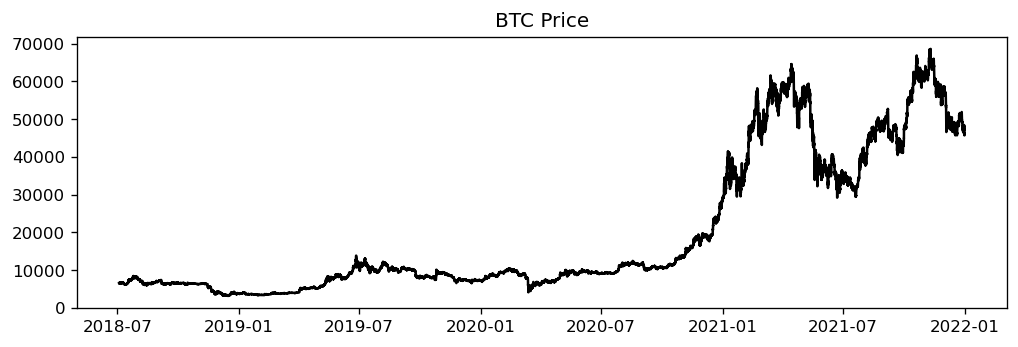

In [4]:
# Plotting our BTC Price

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Close'], color='black')
plt.title('BTC Price')

Text(0.5, 1.0, 'BTC Price Change')

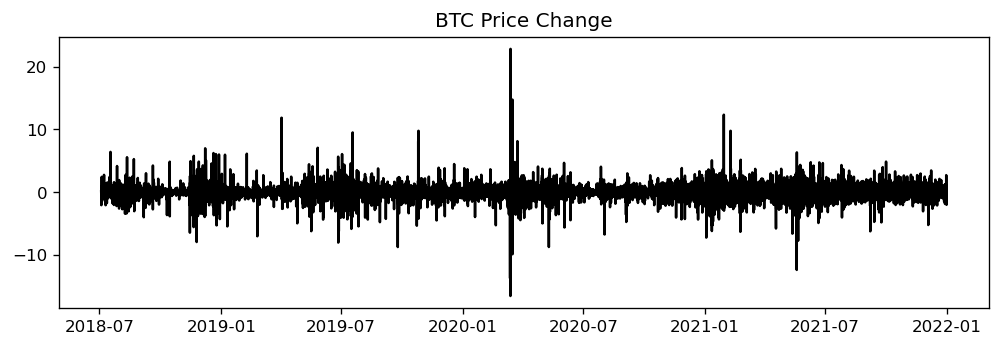

In [5]:
# Plotting our BTC Price

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Percent Change'], color='black')
plt.title('BTC Price Change')

Text(0.5, 1.0, 'BTC Price Change Training Data')

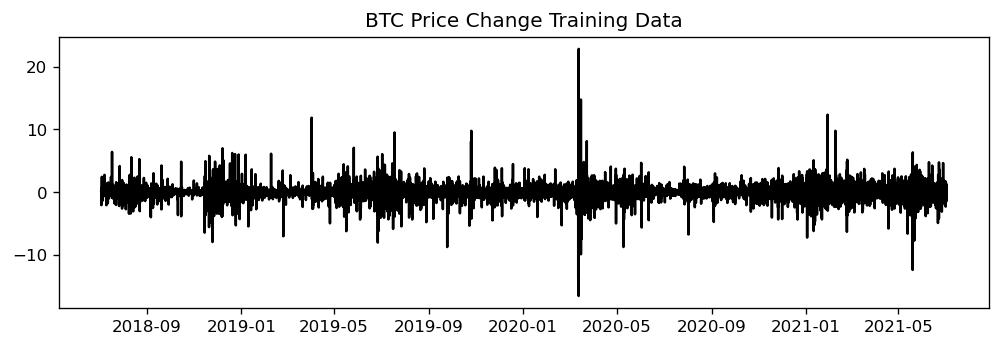

In [6]:
# Plotting our BTC Price

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Percent Change'][:'2021-07-02 11:00:00'], color='black')
plt.title('BTC Price Change Training Data')

Text(0.5, 1.0, 'BTC Price Change Testing Data')

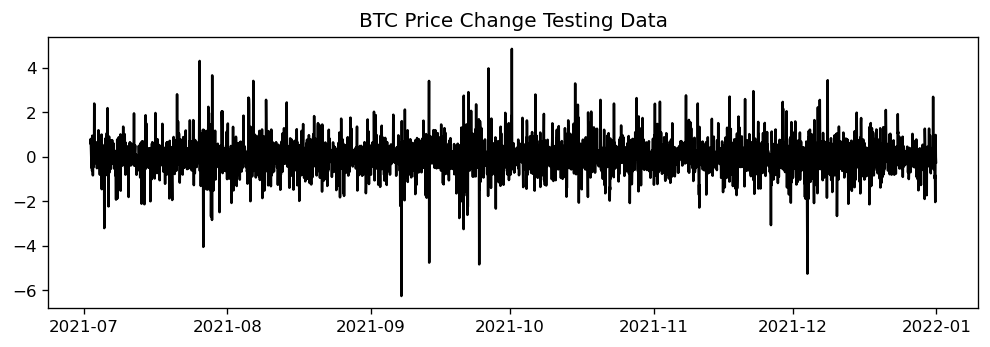

In [7]:
# Plotting our BTC Price

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(X['Percent Change']['2021-07-02 11:00:00':], color='black')
plt.title('BTC Price Change Testing Data')

Note: This section strongly follows the following guide https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ and https://towardsai.net/p/machine-learning/stock-price-change-forecasting-with-time-series-sarimax

# Autoregressive Integrated Moving Average Model

### Parameters of the ARIMA model

The mathematical formulation of the $ARIMA(p,d,q)$ model is the following:

$$\phi(L)^p\Delta^dy_t=\theta(L)^q\epsilon_t$$

$p$ is number of lag observations included in the model, also called the lag order, $d$ is number of times that the raw observations are differenced, also called the degree of differencing, $q$ is size of the moving average window, also called the order of moving average, and $L$ is the lag operator.

### Differencing to Determine d

To begin, we need to determine whether or not to difference the data to make it more stationary. This will give us our parameter $d$.

We will use the Augmented Dickey Fuller Test to see if $d$ should be anything other than 0, nothing that by looking at only the price change, we already have a difference of 1.

In [8]:
result = adfuller(X['Percent Change']['2021-07-02 11:00:00':])
print('ADF Statistic for BTC Percent Change is '+str(result[0]))
print('p-value for BTC Percent Change is ' +str(result[1]))

ADF Statistic for BTC Percent Change is -64.75818353224876
p-value for BTC Percent Change is 0.0




We see that the data is stationary, so we will turn off differencing in the Auto-SARIMAX

### Auto-Correlation Plot to determine MA(q)

[]

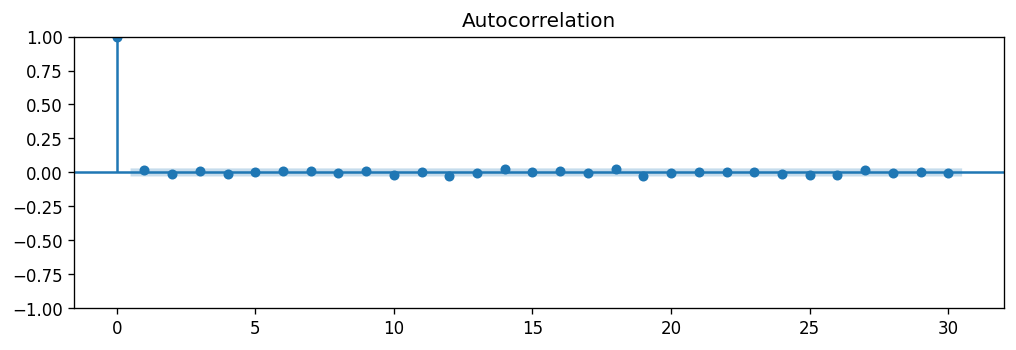

In [9]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plot_acf(X['Percent Change']['2021-07-02 11:00:00':].dropna(), lags=30)
plt.plot()

There seems to be no obvious spike.

### Partial Autocorrelation plot to determine AR(p)

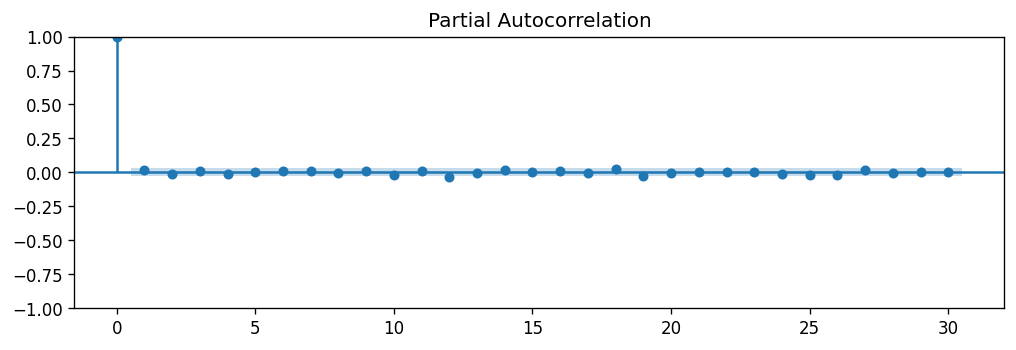

In [10]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plot_pacf(X['Percent Change']['2021-07-02 11:00:00':].dropna(), lags=30)
plt.show()

There seems to be a no obvious spike

Our data has negative values, so Multiplicative Decomposition is not appropriate

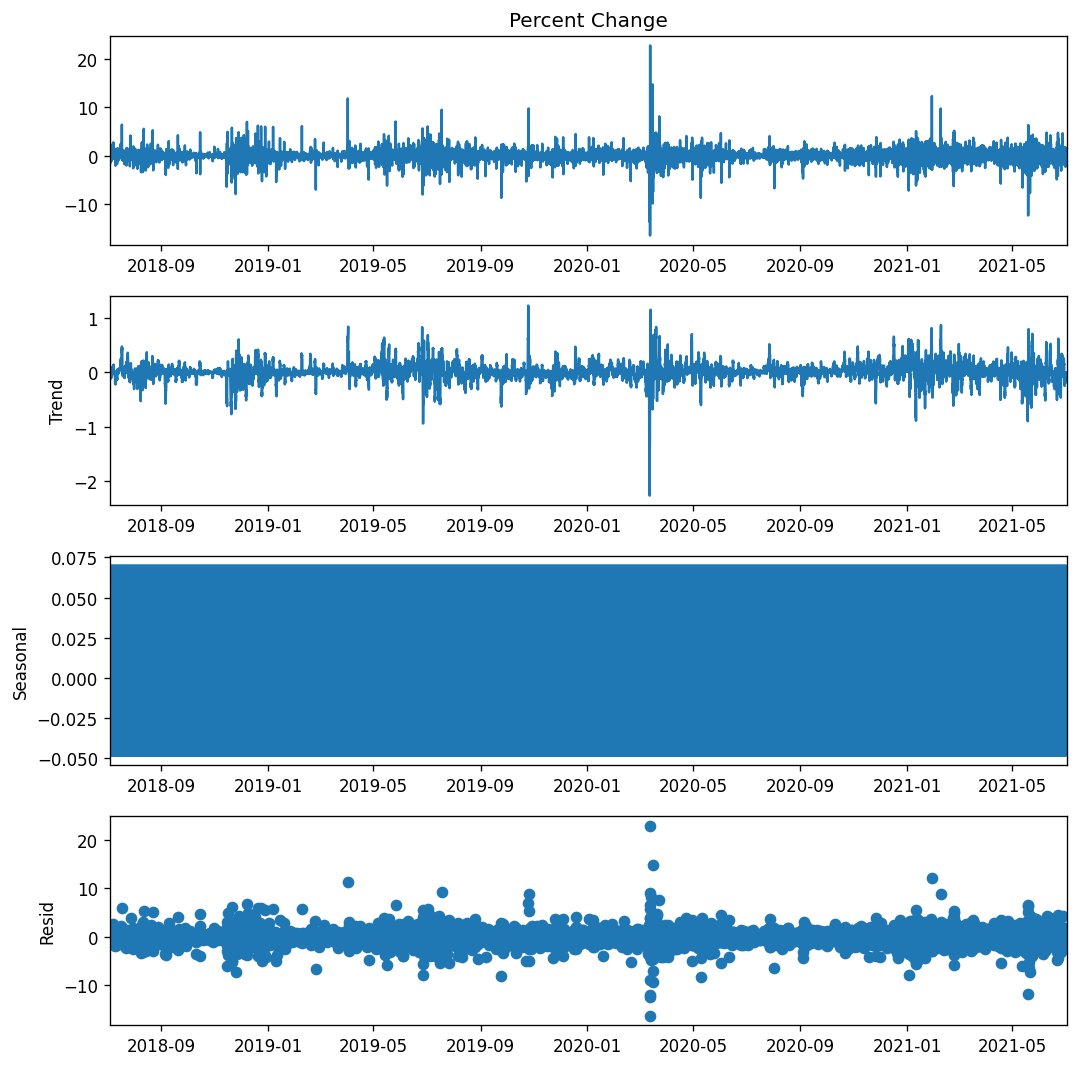

In [11]:
## from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Additive Decomposition
additive_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(X['Percent Change'][:'2021-07-02 11:00:00'],
                                                                     model='additive')

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

plt.show()

Importantly, we see no trend.

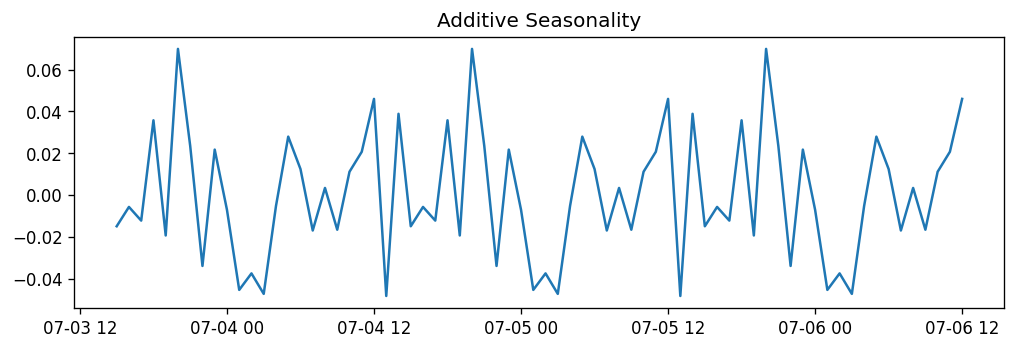

In [12]:
# Plotting seasonality

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
add_season=additive_decomposition.seasonal[0:70]
plt.plot(add_season)
plt.title('Additive Seasonality')
plt.show()

Though it is hard to see in the original plot, on a shorter scale, we can find seasonaility in the 24-hour time-frame period. This justifies the use of a SARIMA model, or an ARIMA model with a seasonal component.

# Seasonal Autoregressive Integrated Moving Average with eXogenous Variables Model

Though we could use the values we found by looking at the above plots to construct our SARIMA model, we will use the Auto-ARIMA function in statsmodels. We will also augment it with exogenous variables to get a SARIMAX model.

The mathematical form of a $SARIMAX(p,d,q,)(P,D,Q)_m$ model is:

$$y_t=\sum_{i=1}^{r} \beta_i x_i+u_t$$

$$\phi(L)^p {\tilde{\phi}}(L^m)^P\Delta^d{\Delta_m^D}u_t=A(t)+\theta(L)^q{\tilde{\theta}}(L^m)^Q\epsilon_t$$

However, we note that we can treat the $A(t)$ term as zero from above.

## Data Preparation

In [14]:
# Defining a function to create PCA matrices

def PCA_creation_train_test(no_components, X_train, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling X_test 
    X_test=scaler.transform(X_test)

    # Transforming X_test
    X_test=pca.transform(X_test)
    
    return X_train, X_test

In [15]:
y=X['Percent Change']

X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)

# Removing the testing data
X_test=X[-4380:].astype('float32') # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].astype('float32')

X=X[:-4380].astype('float32') # Getting everything but the first 6 months as the training data
y=y[:-4380].astype('float32')

X_train, X_test=PCA_creation_train_test(20, X, X_test)
y_train=y

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


## Auto-SARIMAX

In [8]:
# We must set the 'stationary' to True, as our data is already stationary and d=0
auto_model = auto_arima(y_train, exogenous=X_train,
                        m=24, seasonal=True, suppress_warnings = True,  step_wise=False, trace=True,
                       stationary=True)

auto_model.summary()

From Auto-SARIMAX run on the clusters we find the best model, by lowest AIC, is ARIMA(2,0,2)(1,0,1)[24] intercept. Total fit time: 16781.847 seconds. AIC=65433.691

# SARMAX with the best parameters identified by Auto-SARIMAX

## Training

In [ ]:
start=time.time()
model = SARIMAX(endog=y_train, exog=X_train, 
                order=(2, 0, 2),seasonal_order=(1, 0, 1, 24))
model = model.fit(disp=False)
model.summary()
end=time.time()
print('This SARMAX training took', end-start)

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Percent Change   No. Observations:                26276
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 24)   Log Likelihood              -32692.243
Date:                              Thu, 24 Mar 2022   AIC                          65438.487
Time:                                      16:05:51   BIC                          65659.250
Sample:                                  07-03-2018   HQIC                         65509.771
                                       - 07-02-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003      0.001      0.412      0.680      -0.001       0.002
x2            -0.0088      0.001     -8.902      0.000      -0.011      -0.007
x3             0.0077      0.001      5.242      0.000       0.005       0.011
x4            -0.0017      0.002     -0.999      0.318      -0.005       0.002
x5             0.0045      0.001      4.350      0.000       0.002       0.007
x6             0.0051      0.002      2.130      0.033       0.000       0.010
x7             0.0021      0.003      0.813      0.416      -0.003       0.007
x8            -0.0095      0.003     -2.919      0.004      -0.016      -0.003
x9             0.0084      0.004      2.050      0.040       0.000       0.016
x10           -0.0171      0.004     -4.248      0.000      -0.025      -0.009
x11           -0.0050      0.004     -1.313      0.189      -0.012       0.002
x12           -0.0152      0.006     -2.663      0.008      -0.026      -0.004
x13            0.0050      0.005      0.974      0.330      -0.005       0.015
x14            0.0105      0.005      2.125      0.034       0.001       0.020
x15            0.0189      0.006      3.008      0.003       0.007       0.031
x16            0.0095      0.006      1.682      0.093      -0.002       0.021
x17           -0.0065      0.009     -0.754      0.451      -0.023       0.010
x18           -0.0102      0.008     -1.201      0.230      -0.027       0.006
x19           -0.0021      0.011     -0.186      0.852      -0.024       0.020
x20            0.0341      0.011      3.136      0.002       0.013       0.055
ar.L1         -0.1157      0.060     -1.913      0.056      -0.234       0.003
ar.L2          0.5180      0.049     10.485      0.000       0.421       0.615
ma.L1          0.0498      0.060      0.832      0.405      -0.068       0.167
ma.L2         -0.5874      0.052    -11.192      0.000      -0.690      -0.485
ar.S.L24       0.1653      0.081      2.049      0.040       0.007       0.323
ma.S.L24      -0.2175      0.080     -2.716      0.007      -0.374      -0.061
sigma2         0.7054      0.002    470.026      0.000       0.702       0.708
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):           2661703.57
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Diagnostics

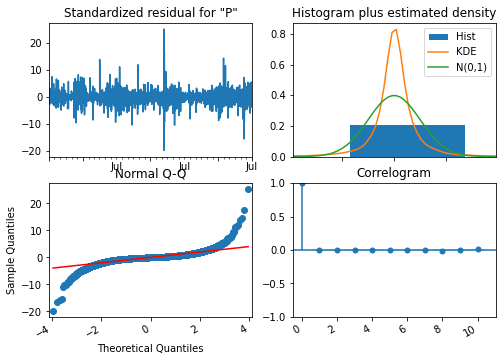

In [8]:
model.plot_diagnostics(figsize=(8,6))
plt.gcf().autofmt_xdate()
plt.show()

## Out-Of-Sample Forecasting

In [1]:
result = model.predict(start=len(X), end=len(X)+len(X_test)-1, exog=X_test.astype(float))

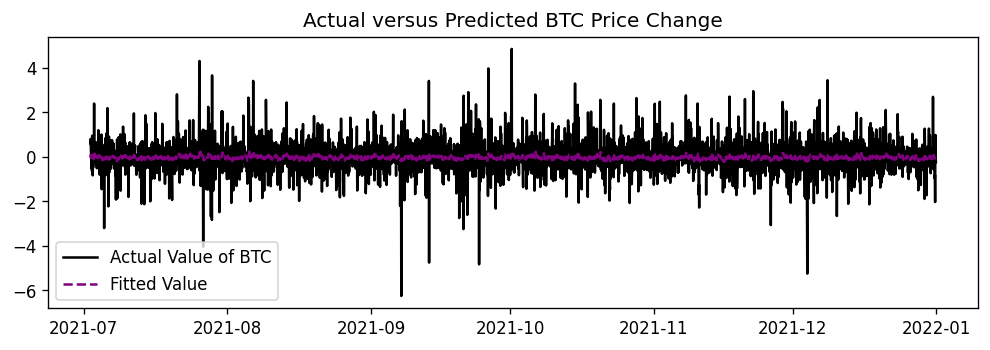

In [10]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(y_test, label='Actual Value of BTC', color='black')
plt.plot(result, label='Fitted Value', color='purple', linestyle='--')
plt.title('Actual versus Predicted BTC Price Change')
plt.legend()

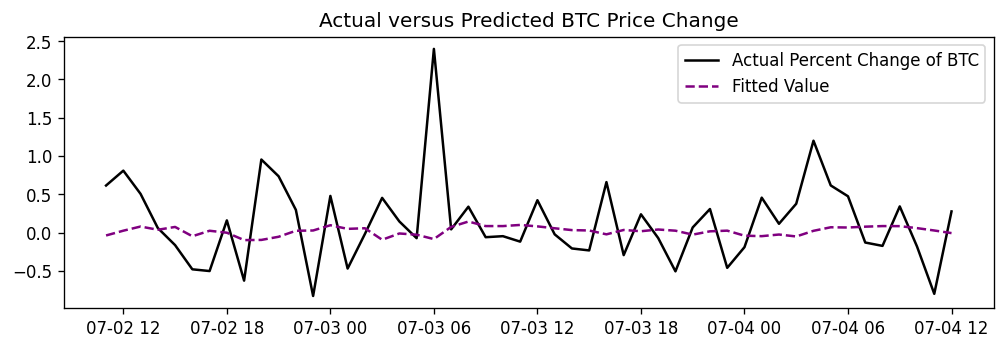

In [11]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(y_test[0:50], label='Actual Percent Change of BTC', color='black')
plt.plot(result[0:50], label='Fitted Value', color='purple', linestyle='--')
plt.title('Actual versus Predicted BTC Price Change')
plt.legend()

## Saving and Reloading the Model

In [14]:
# Save the model

model.save('Models/BTC 1H SARIMAX.pkl')

In [7]:
# Reload the model

model=SARIMAXResults.load('Models/BTC 1H SARIMAX.pkl')